In [40]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim
from collections import defaultdict

In [41]:
def read_complex(str: str):
    return complex(*[float(elem) for elem in str.split(",")])

def read_spice(filepath: str, convert_complex: bool = False):
    data = pd.read_csv(filepath, header=0, sep="\t")
    for col in data.columns:
        if col not in ["Freq.", "time"] and convert_complex:
            data[col] = data[col].map(read_complex)
    return data

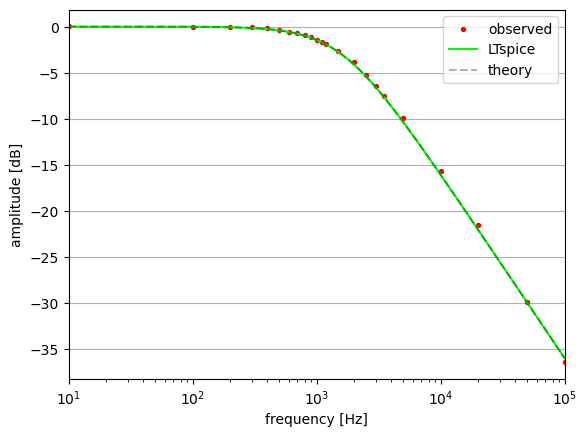

In [42]:
data = read_spice("spice_LPF1.txt", True)
data_plt = pd.read_csv("1-2-a-lpf.csv")
data_plt["h"]=data_plt["v2"]/data_plt["v1"]
h_lpf = lambda s, T: 1/(1+s*T)
h_lpf_abs = lambda f, T: abs(h_lpf(2j*np.pi*f, T))

fig, ax = plt.subplots()

axessetting = AxesSetting(xlim=(1e1, 1e5), xscale="log", legend=True, xlabel="frequency [Hz]", grid="y", ylabel="amplitude [dB]")
ax.scatter(data_plt["frequency"], 20*np.log10(data_plt["h"]), c="red", label="observed", s=8, zorder=2)
ax.plot(data["Freq."], 20*np.log10(np.abs(data["V(n002)"])), c="lime", label="LTspice")
axessetting.plot_func(ax, lambda f: 20*np.log10(h_lpf_abs(f, 1e-4)), label="theory", alpha=0.3, ls="dashed", c="black")
axessetting.apply_axes(ax)

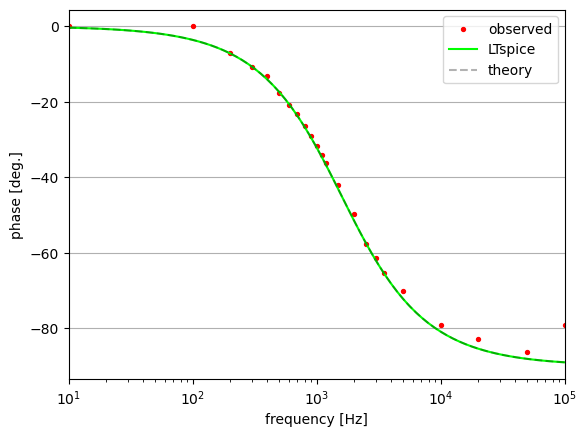

In [43]:
data_plt["phase"]=(-360*data_plt["t"]*data_plt["frequency"]-180) %360 -180
h_lpf_arg = lambda f, T: np.angle(h_lpf(2j*np.pi*f, T), deg=True)

fig, ax = plt.subplots()

axessetting = AxesSetting(xlim=(1e1, 1e5), xscale="log", legend=True, xlabel="frequency [Hz]", grid="y", ylabel="phase [deg.]")
ax.scatter(data_plt["frequency"], data_plt["phase"], c="red", label="observed", s=8, zorder=2)
ax.plot(data["Freq."], np.angle(data["V(n002)"], True), c="lime", label="LTspice")
axessetting.plot_func(ax, lambda f: h_lpf_arg(f, 1e-4), label="theory", alpha=0.3, ls="dashed", c="black")
axessetting.apply_axes(ax)

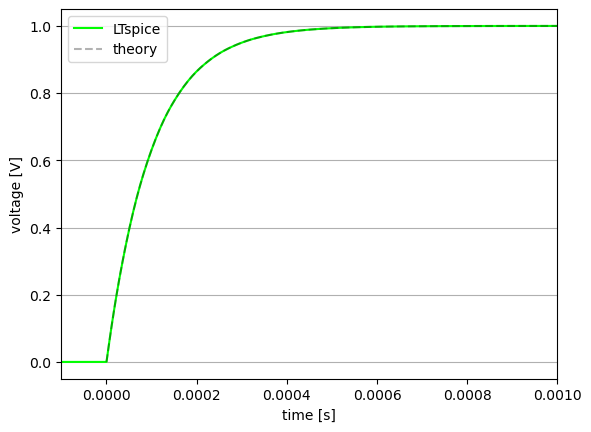

In [44]:
data = read_spice("spice_LPF2.txt")

h_lpf_transient = lambda t, T: 1 - np.exp(-t/T)

fig, ax = plt.subplots()

axessetting = AxesSetting(xlim=(-0.1e-3, 1e-3), legend=True, xlabel="time [s]", grid="y", ylabel="voltage [V]")
ax.plot(data["time"]-1e-3, np.abs(data["V(n002)"]), c="lime", label="LTspice")
axessetting.plot_func(ax, lambda t: h_lpf_transient(t, 1e-4), label="theory", alpha=0.3, ls="dashed", c="black", xlim=(0, 2e-3))
axessetting.apply_axes(ax)

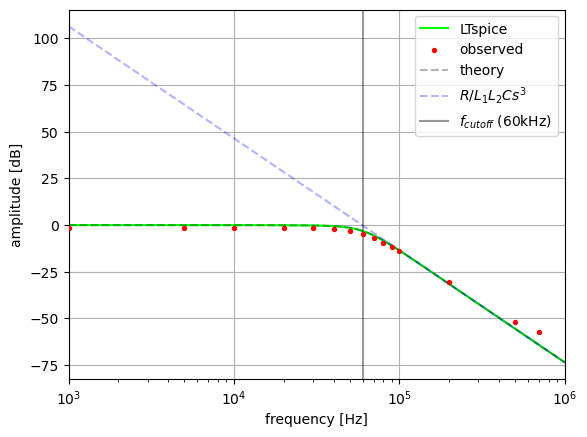

In [56]:
data = read_spice("spice_BWLPF1.txt", True)
data_plt = pd.read_csv("3-c_BW_LPH.csv")
data_plt["h"] = data_plt["V2"]/data_plt["V1"]

h_bw_lpf = lambda s, L1, L2, C, R: 1/(L1*L2*C/R*s**3 + L1*C*s**2 + (L1+L2)/R*s + 1)
h_bw_lpf_abs = lambda f, L1, L2, C, R: abs(h_bw_lpf(2j * np.pi * f, L1, L2, C, R))
h_s3 = lambda f, L1, L2, C, R: 1/(L1*L2*C/R*(2j*np.pi*f)**3)
fig, ax = plt.subplots()

axessetting = AxesSetting(xlim=(1e3, 1e6), xscale="log", legend=True, xlabel="frequency [Hz]", grid="both", ylabel="amplitude [dB]")
ax.plot(data["Freq."], 20*np.log10(np.abs(data["V(n003)"])), c="lime", label="LTspice")
ax.scatter(data_plt["frequency"], 20*np.log10(data_plt["h"]), c="red", label="observed", s=8, zorder=5)
axessetting.plot_func(ax, lambda f: 20*np.log10(h_bw_lpf_abs(f, 141e-6, 47e-6, 0.1e-6, 34.7)), label="theory", alpha=0.3, ls="dashed", c="black")
axessetting.plot_func(ax, lambda f: 20*np.log10(abs(h_s3(f, 141e-6, 47e-6, 0.1e-6, 34.7))), label="$R/L_1L_2Cs^3$", alpha=0.3, ls="dashed", c="blue")
ax.axvline(6e4, alpha=0.4, c="black", label=f"$f_{{cutoff}}$ (60kHz)")
axessetting.apply_axes(ax)

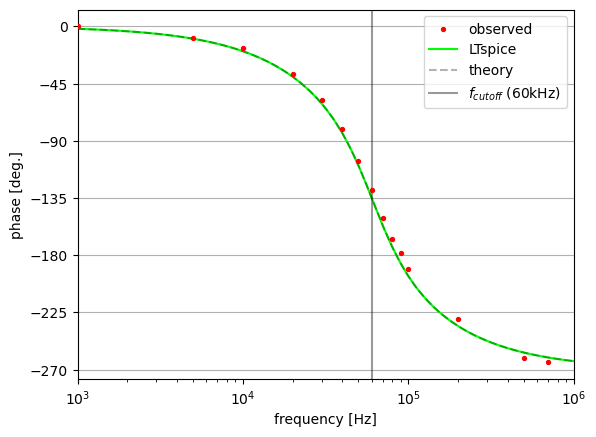

In [50]:
h_bw_lpf_arg = lambda f, L1, L2, C, R: np.angle(h_bw_lpf(2j*np.pi*f, L1, L2, C, R), deg=True)%360-360

fig, ax = plt.subplots()

axessetting = AxesSetting(xlim=(1e3, 1e6), xscale="log", legend=True, xlabel="frequency [Hz]", grid="y", ylabel="phase [deg.]")
ax.scatter(data_plt["frequency"], data_plt["phase"], c="red", label="observed", s=8, zorder=5)
ax.plot(data["Freq."], (np.angle(data["V(n003)"], True)%360)-360, c="lime", label="LTspice")
axessetting.plot_func(ax, lambda f: h_bw_lpf_arg(f, 141e-6, 47e-6, 0.1e-6, 34.7), label="theory", alpha=0.3, ls="dashed", c="black")
ax.axvline(6e4, alpha=0.4, c="black", label=f"$f_{{cutoff}}$ (60kHz)")
axessetting.apply_axes(ax)
ax.set_yticks(np.linspace(-270, 0, 7))